In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

%matplotlib inline

import xgboost as xgb

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer,  mean_absolute_error

from scipy.stats.distributions import uniform

In [2]:
import keras

Using TensorFlow backend.


In [3]:
keras.__version__

'2.2.4'

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Define runtime parameters

In [5]:
FIT_MODELS = True
SAVE_FITTED_MODELS = True
LOAD_FITTED_MODELS = True
CREATE_SUBMISSION_CSV = False

In [6]:
WORKING_DIRECTORY = "D:/data/kaggle/PUBG/"
MODEL_SAVE_DIRECTORY = WORKING_DIRECTORY + "/models"

# Read data

In [35]:
trainingDataPath = WORKING_DIRECTORY + "train.csv"
scoringDataPath = WORKING_DIRECTORY + "test.csv"

In [36]:
trainingData = pd.read_csv(trainingDataPath)
scoringData = pd.read_csv(scoringDataPath)

# Feature engineering

In [51]:
def engineerFeatures(data):
    
    engineered = data.copy()
    
    numPlayersInGroup = (
        engineered.groupby(["matchId", "groupId"]).agg(
            {
                "Id": "count",
            }
        )
        .reset_index()
    )
    numPlayersInGroup.rename(columns={"Id": "numPlayersInGroup"}, inplace=True)
    
    engineered = pd.merge(
        engineered,
        numPlayersInGroup,
        on=["matchId", "groupId"],
        how="left"    
    )
    
    
    return engineered.dropna()

In [52]:
trainingData_engineered = engineerFeatures(trainingData)

# Train test split

Need to do something smarter here:
* split in away that respects matchid and groupIds

Select by matchIds instead

In [53]:
def trainTestSplitByMatchIds(df, matchIdFraction):

    uniqueMatchIds = trainingData_engineered.matchId.unique()
    numTrainingMatches = len(uniqueMatchIds)
    print("Number of unique matches %i " % numTrainingMatches)

    trainMatchIds = np.random.choice(
        uniqueMatchIds, 
        size = int(matchIdFraction* numTrainingMatches), 
        replace=False
    )

    len(trainMatchIds)

    X_train = (
        trainingData_engineered
        .loc[trainingData_engineered.matchId.isin(trainMatchIds)]
        .drop("winPlacePerc", axis="columns")
    )

    y_train = (
        trainingData_engineered
        .loc[trainingData_engineered.matchId.isin(trainMatchIds), "winPlacePerc"]
    )

    X_test = (
        trainingData_engineered
        .loc[~trainingData_engineered.matchId.isin(trainMatchIds)]
        .drop("winPlacePerc", axis="columns")
    )

    y_test = (
        trainingData_engineered
        .loc[~trainingData_engineered.matchId.isin(trainMatchIds), "winPlacePerc"]
    )

    print("Train X, y sizes ", X_train.shape, y_train.shape)
    print("Test X, y sizes ", X_test.shape, y_test.shape)
    
    return X_train, X_test, y_train, y_test

In [54]:
X_train, X_test, y_train, y_test = trainTestSplitByMatchIds(trainingData_engineered, matchIdFraction=0.7)

Number of unique matches 47734 
Train X, y sizes  (3052363, 26) (3052363,)
Test X, y sizes  (1304973, 26) (1304973,)


# Set up model pipelines

In [55]:
def createPreprocessingPipeline():
    preprocPipeline = make_pipeline(
        StandardScaler(with_mean=True, with_std=True)
    )
    
    return preprocPipeline

In [56]:
preprocessingPipeline = createPreprocessingPipeline()

# Set up DNN

In [57]:
selectedFeatures = trainingData.columns.tolist()
# [
#     'assists', 'boosts', 'damageDealt', 'DBNOs',
#        'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
#        'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
#        'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
#        'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
#         "numPlayersInGroup"
# ]

In [58]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input

In [59]:
DnnModel = Sequential()
DnnModel.add(Dense(80,input_dim=len(selectedFeatures),activation='selu'))
# DnnModel.add(Dense(160,activation='selu'))
# DnnModel.add(Dense(320,activation='selu'))
DnnModel.add(Dropout(0.1))
# DnnModel.add(Dense(160,activation='selu'))
# DnnModel.add(Dense(80,activation='selu'))
# DnnModel.add(Dense(40,activation='selu'))
DnnModel.add(Dense(20,activation='selu'))
DnnModel.add(Dense(1,activation='sigmoid'))

In [60]:
DnnModel.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit DNN

In [61]:
# def fitPipelines(preprocessingPipeline, modelPipeline, selectedFeatures, X, y):
    
#     # run preprocessing pipeline on raw data
#     print("Fit preprocessing pipeline")
#     fittedPreprocessingPipeline = preprocessingPipeline.fit(X.loc[:, selectedFeatures], y)
    
#     print("Preprocess data")
#     X_processed = fittedPreprocessingPipeline.transform(X.loc[:, selectedFeatures])
    
#     print("Fit model pipeline")
#     # run the model fitting pipeline on the processed data
#     history = modelPipeline.fit(
#         X_processed, 
#         y,
#         epochs=70, 
#         batch_size=100000
#     )
    
#     # return the fitted preprocessing and modeling pipelines
#     return fittedPreprocessingPipeline, modelPipeline, history

In [63]:
%%time
history = DnnModel.fit(X_train.loc[:, selectedFeatures], y_train, epochs=70, batch_size=100000)

C:\Users\Ulric\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Epoch 1/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 2/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 3/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 4/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 5/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 6/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 7/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 8/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_absolute_error: nan
Epoch 9/70
3052363/3052363 [==============================] - 4s 1us/step - loss: nan - mean_abs

KeyboardInterrupt: 

# Save trained models

In [ ]:
# if SAVE_FITTED_MODELS:
#     joblib.dump(fittedPreprocessing, "./models/preprocessing.pkl")
#     joblib.dump(fittedModelPipeline, "./models/xgbModelPipeline.pkl")

# Load models

In [ ]:
# if LOAD_FITTED_MODELS:
#     fittedPreprocessing = joblib.load("./models/preprocessing.pkl")
#     fittedModelPipeline = joblib.load("./models/xgbModelPipeline.pkl")

# Predict and evaluate on test set

In [35]:
def predictScores(fittedModelPipeline, selectedFeatures, X):
    
    y_preds = fittedModelPipeline.predict(X)

    return y_preds
    
def evalModel(y_true, y_pred, metric_function):
        
    result = metric_function(y_true, y_pred)
    
    plt.figure()
    plt.scatter(y_pred, y_true, alpha = 0.01)
    plt.xlabel("Prediction")
    plt.ylabel("Ground truth")
    
    
    return result

In [36]:
y_user_preds = predictScores(fittedPreprocessing, DnnModel, selectedFeatures, X_test)

In [37]:
def estimateGroupScores(X, y_predictions):
    
    userPreds = X.copy()
    
    userPreds["user_prediction"] = y_predictions
    
    ################
    # Within each match players in the same group have the same score
    
#     aux = userPreds.groupby(['matchId','groupId'])['prediction'].agg('mean').groupby('matchId').rank(pct=True).reset_index()
#     return aux
    
    # get the mean score for users in the group
    groupMeanScores = (
        userPreds
        .groupby(["matchId", "groupId"])["user_prediction"]
        .agg("mean")
    )
    
    
    ######################
    # Within the match rank the scores by group
    matchPctRanks = (
        groupMeanScores
        .groupby(["matchId"])
        .rank(pct=True)
        .reset_index()
    )
    
    matchPctRanks.columns=["matchId", "groupId", "group_prediction"]
    
    # Merge the process scores back into the user data
    userGroupPctRankedScores = pd.merge(
        userPreds,
        matchPctRanks, 
        on = ["matchId", "groupId"],
        how = "left"
    )
    
    return userGroupPctRankedScores

In [38]:
groupData = estimateGroupScores(X_test, y_user_preds)

In [39]:
y_user_preds.shape, groupData.group_prediction.shape

((1307975,), (1307975,))

#### user vs group predictions

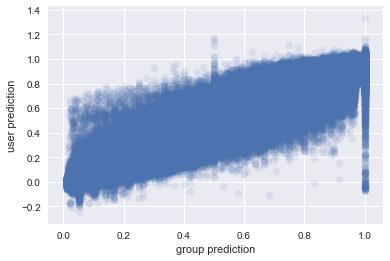

In [40]:
plt.scatter(groupData.group_prediction, y_user_preds, alpha =0.1)
plt.xlabel("group prediction")
plt.ylabel("user prediction")

In [41]:
groupData.group_prediction.describe()

count    1.307975e+06
mean     4.901839e-01
std      2.961671e-01
min      1.000000e-02
25%      2.272727e-01
50%      4.800000e-01
75%      7.500000e-01
max      1.000000e+00
Name: group_prediction, dtype: float64

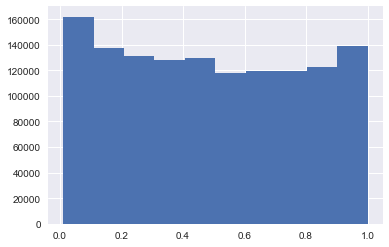

In [42]:
groupData.group_prediction.hist()

In [43]:
y_user_preds_clipped = np.clip(y_user_preds, 0.0, 1.0)

0.06298625453466063

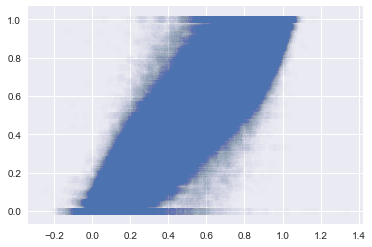

In [44]:
evalModel(y_test, y_user_preds, mean_absolute_error)

0.0627208977818242

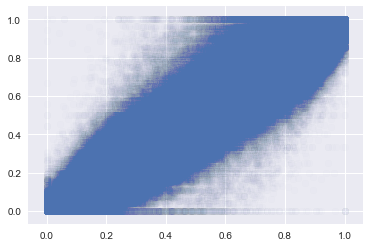

In [45]:
evalModel(y_test, y_user_preds_clipped, mean_absolute_error)

# Group scores look worse

something about our sampling method?

Are some of the groups arbitrarily split between train and test data?

yes...

need to do this for all training data to prevent group splits

Assumes scoring data will have complete groups

0.045394310068542526

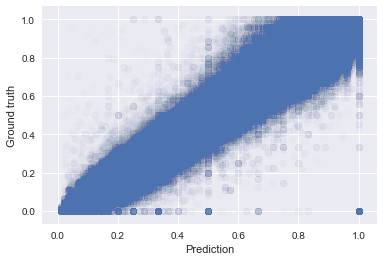

In [58]:
evalModel(y_test, groupData.group_prediction, mean_absolute_error)

# What is the group where we are predicting 1.0 when it is 0.0?

In [61]:
groupData["ground_truth"] = y_test

In [65]:
outliers = (
    groupData
    .loc[
        (groupData.ground_truth == 0) &\
        (groupData.group_prediction > 0.99),
        
    ]
)

In [69]:
outliers.loc[:, selectedFeatures].mean()

assists                 1.269373
boosts                  3.916974
damageDealt           404.490570
DBNOs                   2.105166
headshotKills           0.907749
heals                   3.452030
killPlace              12.081181
killPoints           1144.119926
kills                   3.466790
killStreaks             1.357934
longestKill            78.620417
maxPlace               33.446494
numGroups              32.190037
revives                 0.520295
rideDistance          968.751797
roadKills               0.005535
swimDistance           13.956892
teamKills               0.001845
vehicleDestroys         0.009225
walkDistance         2957.143155
weaponsAcquired         5.369004
winPoints            1523.760148
numPlayersInGroup       3.453875
dtype: float64

In [68]:
groupData.loc[:, selectedFeatures].mean()

assists                 0.264104
boosts                  0.960985
damageDealt           132.573853
DBNOs                   0.682821
headshotKills           0.238408
heals                   1.183197
killPlace              47.046662
killPoints           1080.765118
kills                   0.933045
killStreaks             0.553676
longestKill            19.833017
maxPlace               42.548605
numGroups              41.051399
revives                 0.163473
rideDistance          426.353241
roadKills               0.002569
swimDistance            4.161649
teamKills               0.013786
vehicleDestroys         0.005118
walkDistance         1053.101864
weaponsAcquired         3.451259
winPoints            1500.443213
numPlayersInGroup       3.304347
dtype: float64

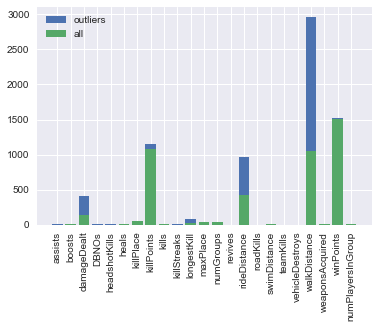

In [77]:
plt.bar(range(len(selectedFeatures)), outliers.loc[:, selectedFeatures].mean(), label="outliers")
plt.bar(range(len(selectedFeatures)), groupData.loc[:, selectedFeatures].mean(), label="all")
plt.xticks(range(len(selectedFeatures)), selectedFeatures, rotation=90)
plt.legend()

([<matplotlib.axis.XTick at 0x28103cb2ba8>,
 <a list of 23 Text xticklabel objects>)

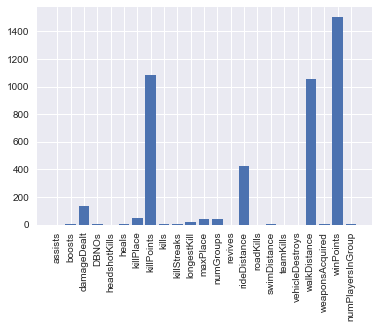

In [75]:
plt.bar(range(len(selectedFeatures)), groupData.loc[:, selectedFeatures].mean())
plt.xticks(range(len(selectedFeatures)), selectedFeatures, rotation=90)

# Submission

In [47]:
scoringData.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,47734,1659463,47734,0,0,100.0,1,0,0,59,...,45,0,0.0,0,0.0,1,0,421.50,7,1500
1,47735,1659508,47735,0,1,400.0,2,0,3,9,...,47,1,0.0,0,0.0,0,0,655.80,4,1526
2,47736,1659555,47736,0,0,0.0,0,0,0,72,...,28,0,0.0,0,0.0,0,0,74.58,1,1475
3,47737,1659621,47737,0,0,68.6,0,0,0,68,...,92,0,0.0,0,0.0,0,0,167.20,2,1464
4,47738,1659675,47738,0,1,370.5,3,0,1,45,...,26,0,0.0,0,0.0,0,0,146.70,3,1505


In [48]:
scoringPreds = engineerFeatures(scoringData)

# user scores
scoringPreds["userPredictions"] = predictScores(fittedPreprocessing, fittedModelPipeline, selectedFeatures, scoringPreds)

In [49]:
scoringGroupPreds = estimateGroupScores(scoringData, scoringPreds["userPredictions"])

In [56]:
(
    scoringGroupPreds
    .loc[:, ["Id", "user_prediction", "group_prediction"]]
).head()

,Id,user_prediction,group_prediction
0,47734,0.468917,0.488889
1,47735,0.554289,0.531915
2,47736,0.278710,0.285714
3,47737,0.344270,0.413043
4,47738,0.142692,0.115385


In [51]:
if CREATE_SUBMISSION_CSV:
    submission = (
        scoringGroupPreds
        .rename(columns={"group_prediction": "winPlacePerc"})
        .loc[:, ["Id", "winPlacePerc"]]
    )
    
    submission.to_csv('submission.csv', index=False)
    
    print(submission.head())